In [1]:
import MetaTrader5 as mt5
import pandas as pd
import pandas_ta as ta
import mplfinance as mpf
import numpy as np

from typing import List, Optional

In [2]:
mt5.initialize()

True

In [24]:
def is_valid_lowest_pivot(df: pd.DataFrame, start_point: pd.Series, end_point: pd.Series) -> bool:
    tmp = df[(df['time'] >= start_point['time']) & (df['time'] <= end_point['time'])]
    lowest_point = tmp.nsmallest(1, 'low').iloc[-1]
    return lowest_point['time'] == end_point['time']

def is_valid_highest_pivot(df: pd.DataFrame, start_point: pd.Series, end_point: pd.Series) -> bool:
    tmp = df[(df['time'] >= start_point['time']) & (df['time'] <= end_point['time'])]
    highest_point = tmp.nlargest(1, 'high').iloc[-1]
    return highest_point['time'] == end_point['time']

def get_highest_pivot_bar(df: pd.DataFrame, pivot_bar: pd.Series, window_size: int = 5) -> Optional[pd.Series]:
    left_bars = df[df['time'] < pivot_bar['time']].tail(window_size)
    right_bars = df[df['time'] > pivot_bar['time']].head(window_size)

    merged_df = pd.concat([left_bars, right_bars])
    # highest_bar = merged_df.nlargest(1, 'high')
    # highest_bar = highest_bar.iloc[-1]
    highest_bar = merged_df[merged_df['pivot_high']]
    if highest_bar.empty:
        return pivot_bar if pivot_bar['pivot_high'] else None
    
    highest_bar = highest_bar.iloc[-1]

    return highest_bar
    # return pivot_bar if highest_bar['high'] < pivot_bar['high'] else highest_bar

def get_lowest_pivot_bar(df: pd.DataFrame, pivot_bar: pd.Series, window_size: int = 5) -> Optional[pd.Series]:
    left_bars = df[df['time'] < pivot_bar['time']].tail(window_size)
    right_bars = df[df['time'] > pivot_bar['time']].head(window_size)
    
    merged_df = pd.concat([left_bars, right_bars])
    # lowest_bar = merged_df.nsmallest(1, 'low')
    # lowest_bar = lowest_bar.iloc[-1]
    lowest_bar = merged_df[merged_df['pivot_low']]
    if lowest_bar.empty:
        return pivot_bar if pivot_bar['pivot_low'] else None
        
    lowest_bar = lowest_bar.iloc[-1]

    return lowest_bar
    # return pivot_bar if lowest_bar['low'] > pivot_bar['low'] else lowest_bar

def is_bearish_divergence(df: pd.DataFrame, current_pivot_high: pd.Series) -> Optional[pd.Series]:
    nearest_rsi_pivot_high = df[(df['rsi_pivot_high']) & (df['time'] < current_pivot_high['time']) & (df['rsi'] > current_pivot_high['rsi'])]
        
    if not nearest_rsi_pivot_high.empty:
        nearest_rsi_pivot_high = nearest_rsi_pivot_high.iloc[-1]
        
        current_pivot_high_candle = get_highest_pivot_bar(df, current_pivot_high)
        nearest_pivot_high_candle = get_highest_pivot_bar(df, nearest_rsi_pivot_high)

        if current_pivot_high_candle is not None and nearest_pivot_high_candle is not None:
            if current_pivot_high_candle['high'] > nearest_pivot_high_candle['high'] \
                    and is_valid_highest_pivot(df, nearest_pivot_high_candle, current_pivot_high_candle):
                return nearest_rsi_pivot_high
            
    return None

def is_bullish_divergence(df: pd.DataFrame, current_pivot_low: pd.Series) -> Optional[pd.Series]:
    nearest_rsi_pivot_low = df[(df['rsi_pivot_low']) & (df['time'] < current_pivot_low['time']) & (df['rsi'] < current_pivot_low['rsi'])]
    
    if not nearest_rsi_pivot_low.empty:
        nearest_rsi_pivot_low = nearest_rsi_pivot_low.iloc[-1]

        current_pivot_low_candle = get_lowest_pivot_bar(df, current_pivot_low)
        nearest_pivot_low_candle = get_lowest_pivot_bar(df, nearest_rsi_pivot_low)
        
        if current_pivot_low_candle is not None and nearest_pivot_low_candle is not None:
            if (current_pivot_low_candle['low'] < nearest_pivot_low_candle['low']) \
                    and is_valid_lowest_pivot(df, nearest_pivot_low_candle, current_pivot_low_candle):
                return nearest_rsi_pivot_low
                
    return None

def is_hidden_bullish_divergence(df: pd.DataFrame, current_pivot_low: pd.Series):
    pass

def is_hidden_bearish_divergence(df: pd.DataFrame, current_pivot_high: pd.Series):
    nearest_rsi_pivot_high = df[(df['pivot_high']) & (df['time'] < current_pivot_high['time']) & (df['high'] > current_pivot_high['high'])]

    if not nearest_rsi_pivot_high.empty:
        nearest_rsi_pivot_high = nearest_rsi_pivot_high.iloc[-1]
        
        current_pivot_high_candle = get_highest_pivot_bar(df, current_pivot_high)
        nearest_pivot_high_candle = get_highest_pivot_bar(df, nearest_rsi_pivot_high)

        if current_pivot_high_candle is not None and nearest_pivot_high_candle is not None:
            if current_pivot_high_candle['rsi'] > nearest_pivot_high_candle['rsi']:
                return nearest_pivot_high_candle
        
    return None

def detect_divergence(df: pd.DataFrame):
    price_lines = []
    rsi_lines = []
    
    for _, current_candle in df.iterrows():
        if current_candle['rsi_pivot_low']:
            bullish_divergence_point = is_bullish_divergence(df, current_candle)
            if bullish_divergence_point is not None:
                rsi_lines.append([
                    (bullish_divergence_point['time'], bullish_divergence_point['rsi']),
                    (current_candle['time'], current_candle['rsi'])
                ])
                
                current_candle = get_lowest_pivot_bar(df, current_candle)
                nearest_pivot_low_candle = get_lowest_pivot_bar(df, bullish_divergence_point)
                price_lines.append([
                    (nearest_pivot_low_candle['time'], nearest_pivot_low_candle['low']),
                    (current_candle['time'], current_candle['low'])
                ])

        if current_candle['rsi_pivot_high']:
            bearish_divergence_point = is_hidden_bearish_divergence(df, current_candle)
            if bearish_divergence_point is not None:
                rsi_lines.append([
                    (bearish_divergence_point['time'], bearish_divergence_point['rsi']),
                    (current_candle['time'], current_candle['rsi'])
                ])

                current_candle = get_highest_pivot_bar(df, current_candle)
                nearest_pivot_high_candle = get_highest_pivot_bar(df, bearish_divergence_point)
                price_lines.append([
                    (nearest_pivot_high_candle['time'], nearest_pivot_high_candle['high']),
                    (current_candle['time'], current_candle['high'])
                ])

    return price_lines, rsi_lines

In [5]:
symbol = 'BTCUSD'

In [22]:
rates = mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_H1, 0, 1000)

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

df['rsi'] = ta.rsi(df['close'], 14)
df['atr'] = ta.atr(df['high'], df['low'], df['close'], 14)

df.dropna(inplace=True)

window_size = 5
df['rsi_pivot_high'] = df['rsi'] == df['rsi'].rolling(2 * window_size + 1, center=True).max()
df['rsi_pivot_low'] = df['rsi'] == df['rsi'].rolling(2 * window_size + 1, center=True).min()
df['pivot_high'] = df['high'] == df['high'].rolling(2 * window_size + 1, center=True).max()
df['pivot_low'] = df['low'] == df['low'].rolling(2 * window_size + 1, center=True).min()

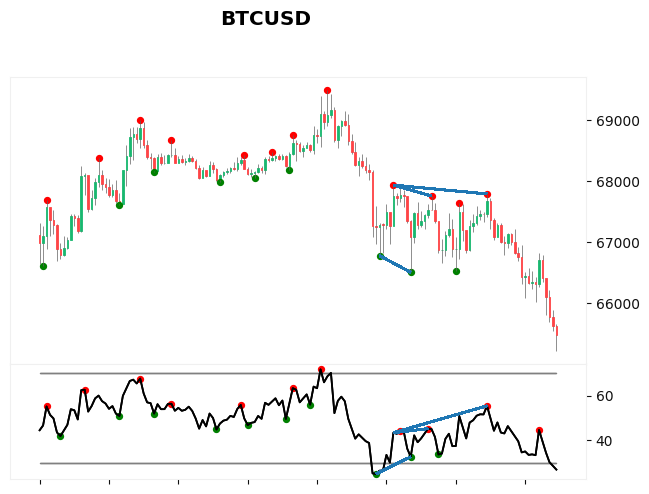

: 

In [25]:
df = df.tail(150)
df.set_index(df['time'], inplace=True)

price_lines, rsi_lines = detect_divergence(df)

rsi_pivot_highs = np.where(df['rsi_pivot_high'], df['rsi'], np.nan)
rsi_pivot_lows = np.where(df['rsi_pivot_low'], df['rsi'], np.nan)
pivot_highs = np.where(df['pivot_high'], df['high'], np.nan)
pivot_lows = np.where(df['pivot_low'], df['low'], np.nan)

plots = [
    mpf.make_addplot(df['rsi'], panel=1, color='black', fill_between=dict(y1=30, y2=30, color="gray")),
    mpf.make_addplot(df['rsi'], panel=1, color='black', fill_between=dict(y1=70, y2=70, color="gray")),
    mpf.make_addplot(rsi_pivot_highs, panel=1, color='red', type='scatter'),
    mpf.make_addplot(rsi_pivot_lows, panel=1, color='green', type='scatter'),
    mpf.make_addplot(pivot_highs, panel=0, color='red', type='scatter'),
    mpf.make_addplot(pivot_lows, panel=0, color='green', type='scatter'),
]

style = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'grid.alpha':0}, figcolor='#fff', facecolor="#fff")
_, axs = mpf.plot(
    df,
    title=symbol,
    type='candle',
    style=style,
    volume=False,
    ylabel='',
    ylabel_lower='',
    datetime_format='',
    addplot=plots,
    returnfig=True,
    alines=dict(alines=price_lines),
)

rsi_lines = mpf._utils._construct_aline_collections(dict(alines=rsi_lines), df.index)
axs[2].add_collection(rsi_lines);

In [3]:
symbol = 'BTCUSD'

rates = mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_M1, 0, 1000)

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df['atr'] = ta.atr(df['high'], df['low'], df['close'], 14)

order_type = mt5.ORDER_TYPE_BUY_STOP
# info_tick = mt5.symbol_info_tick(symbol)
atr = df['atr'].iloc[-2]
close = df['close'].iloc[-2]
# entry = 0
# stop_loss = 0

# match order_type:
#     case mt5.ORDER_TYPE_BUY:
#         entry = info_tick.ask
#         stop_loss = entry - atr * 5
#     case mt5.ORDER_TYPE_SELL:
#         entry = info_tick.bid
#         stop_loss = entry + atr * 5

trade_volume = 0.1
sell_e = close - atr
buy_e = close + atr

sl_sell_e = sell_e
sl_buy_e = buy_e

for e, sl, order in [[sell_e, sl_sell_e, mt5.ORDER_TYPE_SELL_STOP], [buy_e, sl_buy_e, mt5.ORDER_TYPE_BUY_STOP]]:
    request = {
        "action": mt5.TRADE_ACTION_PENDING,
        'symbol': symbol,
        "volume": trade_volume,
        "type": order,
        "price": e,
        "sl": sl,
        'deviation': 30,
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_IOC,
    }
    result = mt5.order_send(request)
    print(result)

OrderSendResult(retcode=10009, deal=0, order=85818929, volume=0.1, price=0.0, bid=67051.08, ask=67072.18000000001, comment='', request_id=2296609295, retcode_external=0, request=TradeRequest(action=5, magic=0, order=0, symbol='BTCUSD', volume=0.1, price=66984.9540958095, stoplimit=0.0, sl=66984.9540958095, tp=0.0, deviation=30, type=5, type_filling=1, type_time=0, expiration=0, comment='', position=0, position_by=0))
OrderSendResult(retcode=10009, deal=0, order=85818955, volume=0.1, price=0.0, bid=67052.73, ask=67073.83, comment='', request_id=2296609296, retcode_external=0, request=TradeRequest(action=5, magic=0, order=0, symbol='BTCUSD', volume=0.1, price=67085.1059041905, stoplimit=0.0, sl=67085.1059041905, tp=0.0, deviation=30, type=4, type_filling=1, type_time=0, expiration=0, comment='', position=0, position_by=0))


In [5]:
info_tick = mt5.symbol_info_tick(symbol)
request = {
    'symbol': 'BTCUSD',
    'deviation': 30,
    'action': mt5.TRADE_ACTION_DEAL,
    'type': mt5.ORDER_TYPE_BUY,
    'volume': trade_volume,
    'price': info_tick.ask,
}
mt5.order_send(request)

OrderSendResult(retcode=10009, deal=70626710, order=85825595, volume=0.1, price=67071.24, bid=67050.14, ask=67071.24, comment='', request_id=2296609300, retcode_external=0, request=TradeRequest(action=1, magic=0, order=0, symbol='BTCUSD', volume=0.1, price=67071.23, stoplimit=0.0, sl=0.0, tp=0.0, deviation=30, type=0, type_filling=0, type_time=0, expiration=0, comment='', position=0, position_by=0))

In [12]:
positions = mt5.positions_get(symbol="ETHUSD")
positions

# 2616.03

(TradePosition(ticket=241787641, time=1724325602, time_msc=1724325602768, time_update=1724325602, time_update_msc=1724325602768, type=1, magic=0, identifier=241787641, reason=3, volume=4.83, price_open=2636.7400000000002, sl=2616.03, tp=2583.0, price_current=2597.92, swap=0.0, profit=187.5, symbol='ETHUSD', comment='', external_id=''),)

In [7]:
request = {
    'action': mt5.TRADE_ACTION_SLTP,
    'position': positions[0].ticket,
    'sl': 1.29835,
    'commnet': 'test'
}
result = mt5.order_send(request)
result

OrderSendResult(retcode=10009, deal=0, order=0, volume=0.2, price=1.30012, bid=1.3001200000000002, ask=1.3001200000000002, comment='', request_id=2384262769, retcode_external=0, request=TradeRequest(action=6, magic=0, order=0, symbol='', volume=0.0, price=0.0, stoplimit=0.0, sl=1.29835, tp=0.0, deviation=0, type=0, type_filling=0, type_time=0, expiration=0, comment='', position=210024869, position_by=0))

In [9]:
request = {
    'action': mt5.TRADE_ACTION_MODIFY,
    'position': positions[0].ticket,
    # 'sl': 1.29835,
    'commnet': 'test'
}
result = mt5.order_send(request)
result

OrderSendResult(retcode=10013, deal=0, order=0, volume=0.0, price=0.0, bid=0.0, ask=0.0, comment='Invalid request', request_id=0, retcode_external=0, request=TradeRequest(action=7, magic=0, order=0, symbol='', volume=0.0, price=0.0, stoplimit=0.0, sl=0.0, tp=0.0, deviation=0, type=0, type_filling=0, type_time=0, expiration=0, comment='', position=210024869, position_by=0))